# **LAB 01: TRỰC QUAN HÓA DỮ LIỆU VỚI PYTHON**
#### Môn học: Trực quan hóa dữ liệu
#### Nhóm: 5


## **A. Thu thập dữ liệu**

Đối với một doanh nghiệp, một trong những yếu tố cốt lõi để cấu thành nên sự thành công đó chính là khách hàng. Doanh nghiệp không bán sản phẩm họ cung cấp, mà họ bán sản phẩm mà người khác cần. Thật khó để một doanh nghiệp có thể duy trì nếu họ không có hoặc mất đi những khách hàng của chính họ. Vậy làm thế nào để một doanh nghiệp có thể thu hút ngày càng nhiều khách hàng cũng như đồng thời giữ được những người trung thành, đặc biệt là trong một thị trường đòi hỏi nhiều hơn là chỉ bán dịch vụ và sản phẩm đơn thuần. Chính vì thế, việc tìm hiểu và phân tích nhu cầu khách hàng chính là một trong những việc làm quan trọng, một bài toàn toán khó cho các doanh nghiệp hiện nay.

Thấy được tầm quan trọng của việc phân tích khách hàng, nhóm 5 lựa chọn bộ dữ liệu *Shop Customer Data* cho lab 01. Bộ dữ liệu được chia sẻ miễn phí trên nền tảng Kaggle. (Link dataset: https://www.kaggle.com/datasets/datascientistanna/customers-dataset)

License: <a href="http://opendatacommons.org/licenses/dbcl/1.0/">Database: Open Database, Contents: Database Contents</a>


Bộ dữ liệu được thu thập thủ công. Phương pháp thu thâp là thu thập thông qua nghiên cứu kéo dài 1 năm về khách hàng của các cửa hàng địa phương.


## **B. Khám phá dữ liệu**

### **Import các thư viện**

In [205]:
import pandas as pd

import seaborn as sns
import plotly.express as px
import plotly.offline as py
import matplotlib.pyplot as plt
import numpy as np


#from sklearn.preprocessing import OneHotEncoder
from sklearn import decomposition
import category_encoders as ce
from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score
from scipy.stats import zscore
from yellowbrick.cluster import KElbowVisualizer

import pingouin as pg #for ANOVA
from joypy import joyplot #ridgeplot is love, ridgeplot is life :>

%matplotlib inline  
py.init_notebook_mode(connected=True)

### **Đọc file dữ liệu vào dataframe**

In [206]:
df=pd.read_csv("Customers.csv")
df.head()


,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


### **Tiền xử lý và khám phá dữ liệu**

**Số dòng** và **số cột** của bộ dữ liệu: 2000 dòng, 8 cột

In [207]:
num_rows, num_cols = df.shape
print("Num rows: ", num_rows)
print("Num cols: ", num_cols)

Num rows:  2000
Num cols:  8


**Ý nghĩa của mỗi dòng**: Thông tin của một khách hàng mua sắm ở cửa hàng. Không có dòng nào mang ý nghĩa khác. 

In [208]:
df.head(1)

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4


Kiểm tra xem có dòng nào bị trùng lặp hay không:

In [209]:
df.duplicated().sum()

0

**Ý nghĩa của mỗi cột**: 

- `Customer ID`: ID khách hàng
- `Gender`: Giới tính
- `Age`: Tuổi
- `Annual Income`: Thu nhập hàng năm (đơn vị: $)
- `Spending Score`: Điểm do cửa hàng chấm, dựa trên hành vi và tính chất chi tiêu của khách hàng. Nằm trong khoảng [0,100]
- `Profession`: Nghề nghiệp
- `Work Experience`: Kinh nghiệm làm việc (đơn vị: năm)
- `Family Size`: Số thành viên trong gia đình

Ta sẽ thực hiện chuẩn hóa tên các cột để thuận tiện hơn cho việc sử dụng về sau:

In [210]:
df = df.rename(columns={'Annual Income ($)': 'Annual_Income',
                        'Spending Score (1-100)': 'Spending_Score',
                        'Work Experience':'Work_Experience',
                        'Family Size':'Family_Size'})
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual_Income', 'Spending_Score',
       'Profession', 'Work_Experience', 'Family_Size'],
      dtype='object')

**Kiểu dữ liệu của mỗi cột:**

In [211]:
df.dtypes

CustomerID          int64
Gender             object
Age                 int64
Annual_Income       int64
Spending_Score      int64
Profession         object
Work_Experience     int64
Family_Size         int64
dtype: object

Các cột đều có kiểu dữ liệu phù hợp, không cần xử lý.

**Kiểm tra giá trị bị thiếu:**

In [212]:
df.isna().sum()

CustomerID          0
Gender              0
Age                 0
Annual_Income       0
Spending_Score      0
Profession         35
Work_Experience     0
Family_Size         0
dtype: int64

Có 35 giá trị thiếu ở cột `Profession`.

**Phân bố giá trị của các cột numerical:**

Dựa vào việc kiểm tra kiểu dữ liệu của các cột ở bước trên, ta đang có 6 cột có vẻ thuộc nhóm **numeric** là: `CustomerID`, `Age`, `Annual_Income`, `Spending_Score`, `Work_Experience`, `Family_Size`. Tuy nhiên, cột `CustomerID` thật ra lại là dạng **categorical** (vì ID là mã được đánh dưới dạng số)

Bảng thống kê cơ bản về các phân bố giá trị của các thuộc tính **numeric**:

In [213]:
df[['Age', 'Annual_Income', 'Spending_Score', 'Work_Experience', 'Family_Size']].describe()

,Age,Annual_Income,Spending_Score,Work_Experience,Family_Size
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,48.960000,110731.821500,50.962500,4.102500,3.768500
std,28.429747,45739.536688,27.934661,3.922204,1.970749
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,25.000000,74572.000000,28.000000,1.000000,2.000000
50%,48.000000,110045.000000,50.000000,3.000000,4.000000
75%,73.000000,149092.750000,75.000000,7.000000,5.000000
max,99.000000,189974.000000,100.000000,17.000000,9.000000


Nhìn tổng quan, khách hàng có tuổi nhỏ nhất là 0. Ta thử truy vấn:

In [214]:
df[df["Age"]==0]

,CustomerID,Gender,Age,Annual_Income,Spending_Score,Profession,Work_Experience,Family_Size
211,212,Female,0,22000,92,Artist,2,1
228,229,Male,0,33000,64,Marketing,1,1
333,334,Male,0,173743,96,Artist,0,4
440,441,Female,0,57373,29,NaN,0,7
443,444,Female,0,68761,16,Lawyer,1,4
466,467,Male,0,186002,80,Doctor,15,2
559,560,Male,0,151298,89,Artist,0,6
562,563,Female,0,142892,25,Entertainment,8,1
767,768,Female,0,143910,22,Marketing,1,7
794,795,Female,0,147719,86,Lawyer,1,7


Có vẻ như người thu thập đã điền giá trị 0 cho các khách hàng không có thông tin về độ tuổi. 

**Phân bố giá trị của các cột categorical:**

Có 3 cột thuộc nhóm **categorical** là: `CustomerID`, `Gender`, `Profession`

Kiểm tra số giá trị trùng lặp ở cột `CustomerID`:

In [215]:
df["CustomerID"].duplicated().sum()

0

Mỗi ID khách hàng là duy nhất, không có sự trùng lặp

Bỏ qua thuộc tính `CustomerID`, ta có bảng thống kê cơ bản về các phân bố giá trị của các thuộc tính **categorical** còn lại:

In [216]:
df[['Gender','Profession']].describe()

,Gender,Profession
count,2000,1965
unique,2,9
top,Female,Artist
freq,1186,612


**Làm sạch dữ liệu:**

Ta lần lượt đi kiểm tra giá trị trong từng cột dữ liệu và tiền xử lý (nếu cần)

**Cột `CustomerID`**: Dựa vào kết quả kiểm tra các bước ở trên, các giá trị ở cột `CustomerID` đều khác nhau nên không có vấn đề gì cần tiền xử lý.

**Cột `Gender`**:

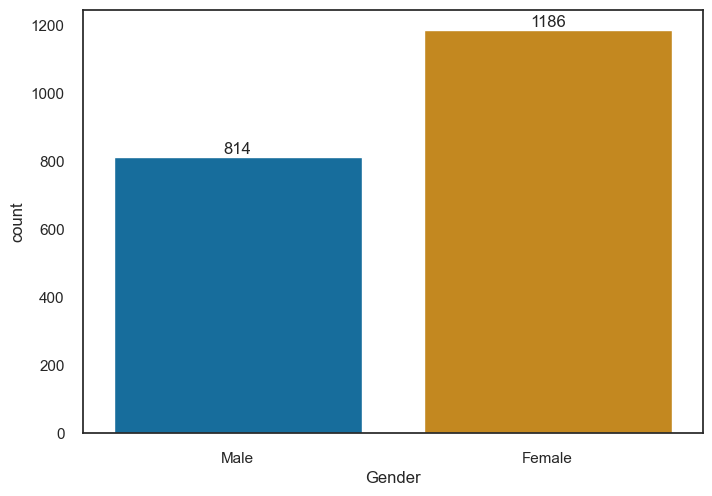

In [217]:
ax=sns.countplot(x='Gender', data=df,palette="colorblind")
ax.bar_label(ax.containers[0]);


**Cột `Profession`**:

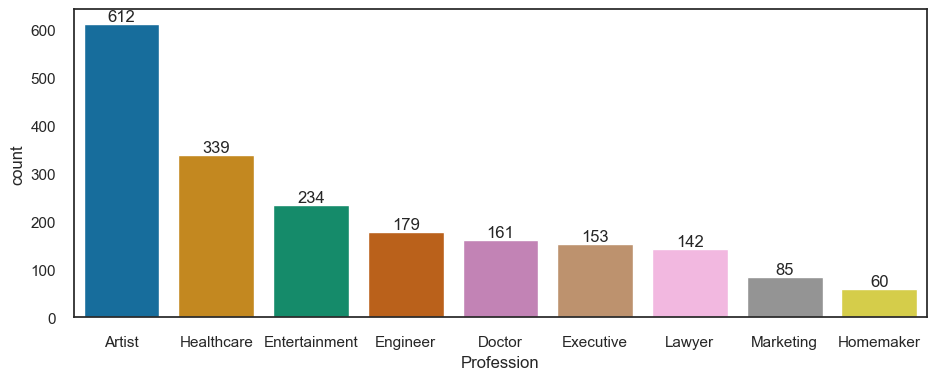

In [218]:
plt.figure(figsize=(11,4))
ax=sns.countplot(x='Profession', data=df,palette="colorblind",order = df['Profession'].value_counts().index)
ax.bar_label(ax.containers[0]);


Điền các giá trị bị thiếu trong cột `Profession` bằng giá trị mới là "other". Việc điền bằng một giá trị mới thay vì dùng các giá trị hiện có sẽ giúp không làm thay đổi nhiều phân bố của các giá trị cũ. Ngoài ra dùng giá trị là 'other', ta không cần train lại mô hình học máy nếu có xuất hiện thêm một vài giá trị `Profession` mới nào khác trong tương lai.

In [219]:
df['Profession'] = df['Profession'].fillna('Other')
df['Profession'].isna().sum()

0

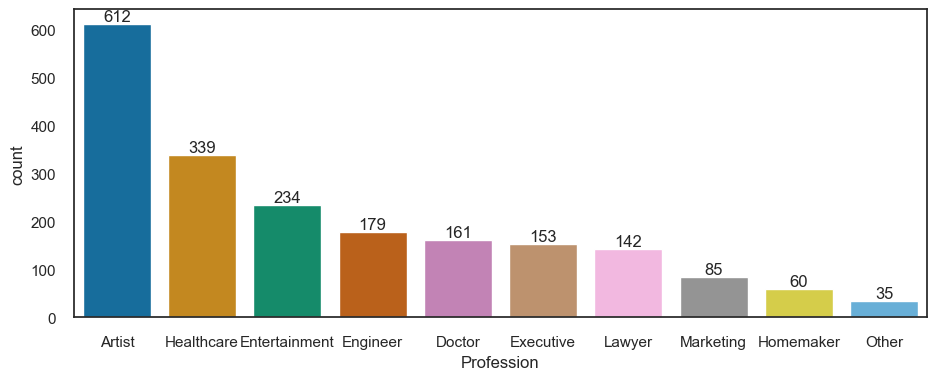

In [220]:
plt.figure(figsize=(11,4))
ax=sns.countplot(x='Profession', data=df,palette="colorblind",order = df['Profession'].value_counts().index)
ax.bar_label(ax.containers[0]);


**Cột `Age`**:

(array([185., 195., 211., 241., 195., 202., 210., 167., 200., 194.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <BarContainer object of 10 artists>)

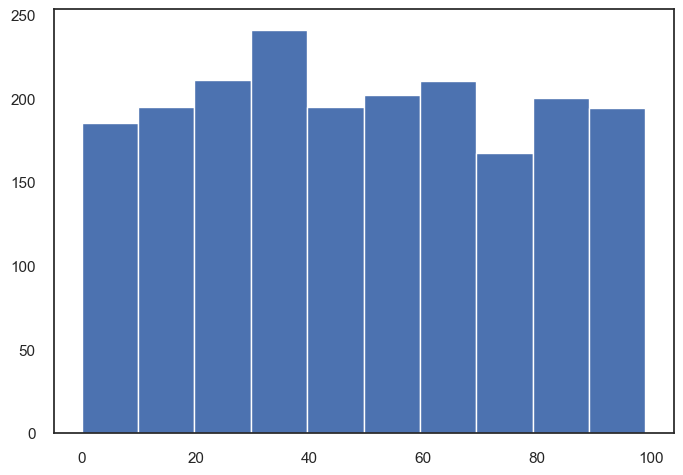

In [221]:
plt.hist(df["Age"])

Phân bố có: vẻ đều từ 0 đến 99 tuổi, nhưng đều này có vẻ không hợp lý vì độ tuổi lao động ít nhất là từ 18 tuổi trở lên. Ta thử truy vấn:

In [222]:
df.query("Age<18")

,CustomerID,Gender,Age,Annual_Income,Spending_Score,Profession,Work_Experience,Family_Size
202,203,Female,16,60000,0,Engineer,6,8
210,211,Female,1,57000,93,Engineer,1,2
211,212,Female,0,22000,92,Artist,2,1
228,229,Male,0,33000,64,Marketing,1,1
229,230,Male,15,94000,30,Healthcare,7,2
...,...,...,...,...,...,...,...,...
1974,1975,Female,14,153145,59,Healthcare,8,6
1979,1980,Male,0,165321,93,Doctor,8,1
1980,1981,Female,10,86925,76,Artist,7,2
1984,1985,Female,2,153622,51,Lawyer,6,6


Ta sẽ thực hiện thay thế những khách hàng có độ tuổi nhỏ hơn 18 bằng độ tuổi trung bình theo `Profession` và `Gender`: 

In [223]:
#df.loc[df["Age"]==0,"Age"]=int(df[df["Age"]>0]["Age"].median())
mean_age = df.groupby(['Gender', 'Profession'])['Age'].mean()

df['Age'] = df.apply(lambda row: int(mean_age[(row['Gender'], row['Profession'])])
                                 if row['Age'] < 18
                                 else row['Age'], axis=1)

**Cột `Annual_Income`**:

In [224]:
fig = px.box(df,x='Annual_Income',width=800, height=400)
fig.show()

In [225]:
fig = px.box(df, y="Annual_Income",x='Age')
fig.show()

Nhìn chung thì có một vài outliers, có thể đây là những trường hợp cá biệt nên ta sẽ không xử lý.

**Cột `Spending_Score`**: là cột do chủ cửa hàng điền.

In [226]:
fig = px.box(df, x="Spending_Score",width=800, height=400)
fig.show()

**Cột `Work_Experience`**:

In [227]:
fig = px.box(df, x="Work_Experience",width=800, height=400)
fig.show()

Nhìn vào đồ thị, ta thấy `Work_Experience` có một giá trị outlier là 17. Thực hiện truy vấn những dòng này:

In [228]:
df.query("Work_Experience==17")

,CustomerID,Gender,Age,Annual_Income,Spending_Score,Profession,Work_Experience,Family_Size
392,393,Male,21,119116,30,Artist,17,4
405,406,Female,65,119889,11,Artist,17,6
473,474,Male,20,130813,92,Artist,17,5
566,567,Female,19,180331,14,Artist,17,5
603,604,Female,91,69720,78,Lawyer,17,6


Mặc dù có dòng có giá trị `Age` chênh lệch khá ít so với `Work_Experience` nhưng nhìn chung những outlier vẫn khá hợp lý (vì `Profession` là "Artist"), ta sẽ giữ lại các dòng này.

Ngoài  `Profession` là *'Artist','Homemaker','Entertainment','Other'* liệu có ai đã bắt đầu làm việc khi dưới 18 tuổi?

In [229]:
df.query("Profession!=['Artist','Homemaker','Entertainment','Other'] and Age-Work_Experience<18 ")

,CustomerID,Gender,Age,Annual_Income,Spending_Score,Profession,Work_Experience,Family_Size
47,48,Female,27,71000,47,Healthcare,12,1
99,100,Male,20,80000,49,Engineer,3,3
115,116,Female,19,51000,50,Executive,8,4
138,139,Male,19,22000,10,Marketing,8,4
353,354,Male,23,181760,35,Healthcare,14,3
355,356,Male,22,172923,20,Engineer,6,1
357,358,Male,20,184324,51,Marketing,13,5
388,389,Female,26,117454,8,Healthcare,16,2
389,390,Female,18,86203,23,Doctor,13,1
407,408,Male,18,103896,36,Executive,16,4


Ta sẽ loại bỏ những dòng này:

In [230]:
df = df.drop(df.query("Profession!=['Artist','Homemaker','Entertainment','Other'] and Age-Work_Experience<18 ").index)

**Cột `Family_Size`:**

In [231]:
fig = px.box(df, x="Family_Size",width=800, height=400)
fig.show()

Dataframe sau khi thực hiện tiền xử lý:

In [232]:
df

,CustomerID,Gender,Age,Annual_Income,Spending_Score,Profession,Work_Experience,Family_Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6
...,...,...,...,...,...,...,...,...
1995,1996,Female,71,184387,40,Artist,8,7
1996,1997,Female,91,73158,32,Doctor,7,7
1997,1998,Male,87,90961,14,Healthcare,9,2
1998,1999,Male,77,182109,4,Executive,7,2


In [233]:
df['Profession'].unique()

array(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
       'Executive', 'Doctor', 'Homemaker', 'Marketing', 'Other'],
      dtype=object)

#### **C. Khám phá mối quan hệ trong dữ liệu**

Dùng chung `df` để đỡ phải sửa khi merge nha

**Mối Quan Hệ Giữa 2 Thuộc Tính: `Age` và `Annual Income`**

Ta trực quan hóa dữ liệu của 2 thuộc tính bằng Scatter plot:

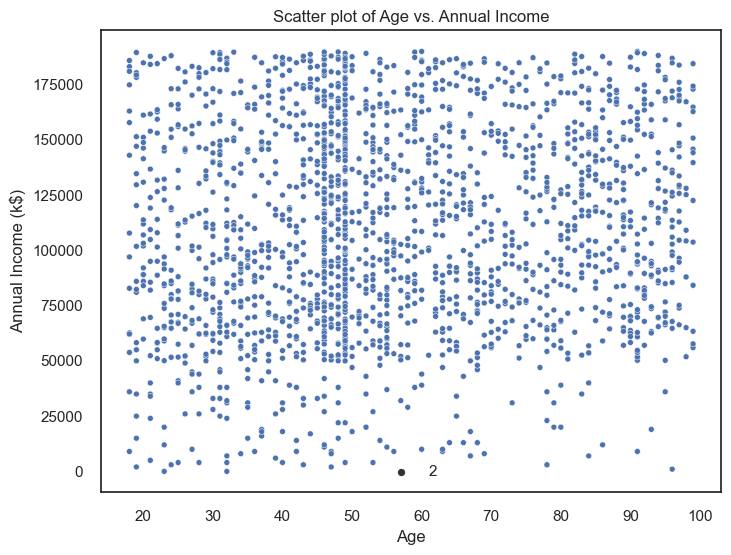

In [234]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Age', y='Annual_Income', data=df,size=2)
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.title('Scatter plot of Age vs. Annual Income')
plt.show()

Scatter plot cho thấy sự phân tán của dữ liệu giữa độ tuổi và thu nhập hàng năm của các khách hàng. Nhìn tổng quan có một số trường hợp như:

- Một số khách hàng có độ tuổi cao và thu nhập hàng năm cao.
- Một số khách hàng có độ tuổi cao và thu nhập hàng năm thấp.
- Một số khách có độ tuổi thấp nhưng thu nhập hàng năm lại cao.
- Một số khách có độ tuổi thấp và thu nhập hàng năm thấp.
- Một số khách có độ tuổi trung bình và thu nhập cũng trung bình.
- Có thể thấy rằng không có mối quan hệ tuyệt đối giữa độ tuổi và thu nhập hàng năm, mặc dù có thể nhận thấy xu hướng chung cho rằng thu nhập hàng năm có xu hướng tăng khi độ tuổi tăng.

Ta thử xem giá trị **correlation coefficient**:

Correlation_coefficient:  0.0899309943330235


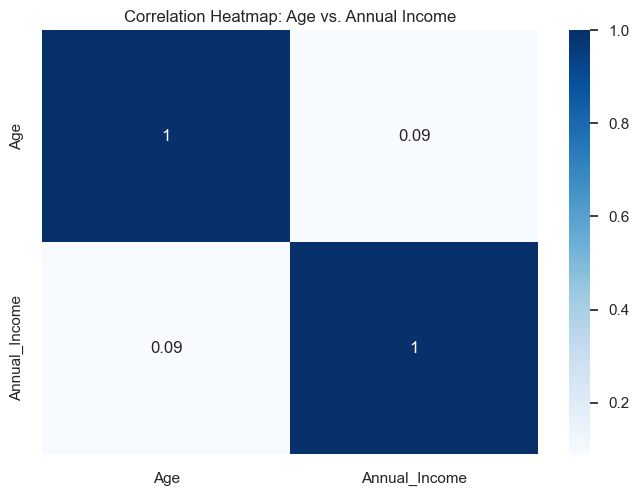

In [235]:
corr = df['Age'].corr(df['Annual_Income'])
print("Correlation_coefficient: ",corr)

sns.set(style='white')
sns.heatmap(df[['Age', 'Annual_Income']].corr(), annot=True, cmap='Blues')

plt.title('Correlation Heatmap: Age vs. Annual Income')
plt.show()

Từ biểu đồ Heatmap, ta có thể thấy chính xác rằng mức độ tương quan giữa độ tuổi và thu nhập hàng năm không cao lắm (correlation coefficient = 0.09/1), được biểu thị bởi màu sắc xanh rất nhạt.

Tổng quan, phân tích hai biểu đồ cho thấy rằng không có một mối quan hệ rõ ràng giữa độ tuổi và thu nhập hàng năm của khách hàng trong tập dữ liệu này. Tuy nhiên, ta có thể nhận thấy rằng có một số khách hàng có độ tuổi trung bình cao hơn và thu nhập hàng năm cao hơn, và ngược lại có một số khách hàng có độ tuổi trẻ hơn nhưng thu nhập hàng năm lại cao hơn.

Hai biến có độ tương quan thấp thì đó có thể làm cho mô hình học máy không hiệu quả hoặc không chính xác. Trong mô hình học máy, các thuật toán phụ thuộc vào đầu vào để dự đoán đầu ra, nếu hai biến đầu vào không có mối tương quan với nhau, mô hình có thể không tìm ra được mối quan hệ giữa chúng và không thể dự đoán đầu ra chính xác.

**Mối Quan Hệ Giữa 2 Thuộc Tính: `Work Experience` và `Profession`**

Trước tiên, ta sử dụng ridgeline plot (thực ra là nhiều density plot chồng lên nhau) để biểu diễn phân bố dữ liệu giữa 2 cột Work Experience và Profession:

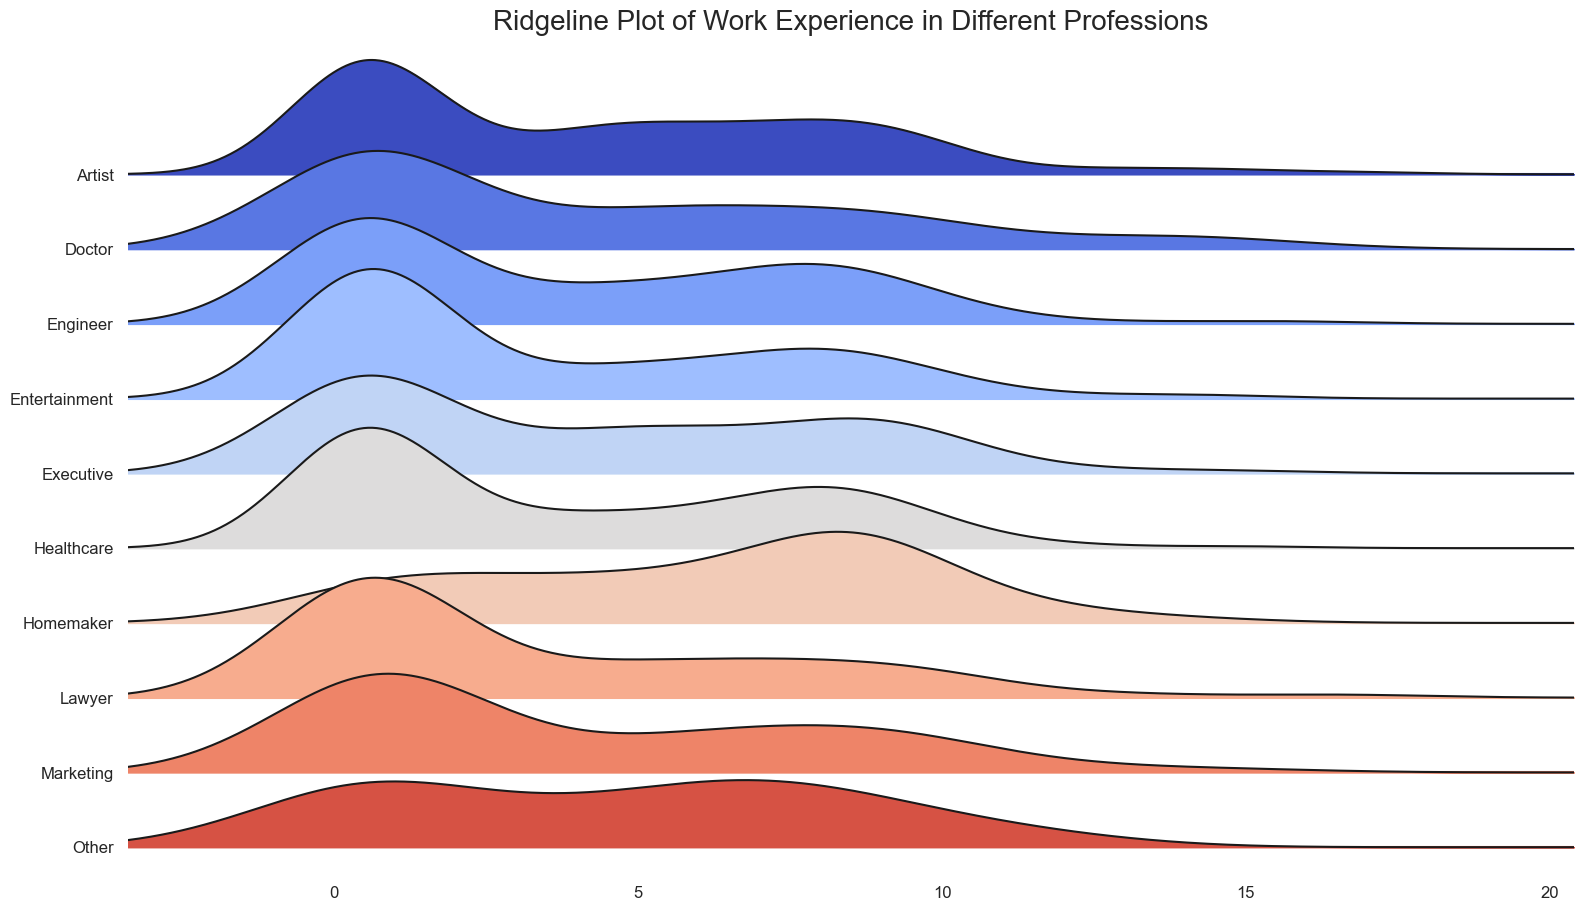

In [236]:
joyplot(data=df[['Work_Experience', 'Profession']], by='Profession', figsize = (16,9), colormap = plt.cm.coolwarm)
plt.title('Ridgeline Plot of Work Experience in Different Professions', fontsize = 20)
plt.show()

Một số quan sát thông qua việc trực quan hóa dữ liệu: 

- Phần lớn các nhóm ngành nghề đều có phân bố tuổi nghề cao nhất ở khoảng 0-2 năm, sau đó phân bố giảm dần.
- Một số ngành nghề như Engineer, Entertainment và Healthcare có phân bố tăng nhẹ ở khoảng 8-10 năm tuổi nghề.
- Riêng nhóm ngành nghề Homemaker (giúp việc nhà) lại có phân bố tuổi nghề tăng dần và cao nhất ở khoảng 8-10 năm.
- Ngành Doctor (bác sĩ) có nhiều người có tuổi nghề cao nhất.

Tuy nhiên, từ những quan sát này chưa thể rút ra rằng có mối tương quan giữa ngành nghề và tuổi nghề hay không, vì vậy ta sẽ sử dụng **phương pháp ANOVA** (phân tích phương sai) để nghiên cứu ảnh hưởng của ngành nghề lên tuổi nghề. Ta sử dụng phương pháp này do biến Profession là biến định tính gồm nhiều nhóm khác nhau và Work_Experience là biến định lượng.

**Giả thuyết H0:** trung bình giá trị giữa các nhóm bằng nhau, tức là biến nguyên nhân định tính không có tác động gì lên kết quả của biến định lượng.

**Đối thuyết H1:** biến nguyên nhân định tính ảnh hưởng đến biến định lượng.

In [237]:
pg.welch_anova(dv='Work_Experience', between='Profession', data=df)

,Source,ddof1,ddof2,F,p-unc,np2
0,Profession,9,392.57306,3.655079,0.00021,0.014671


Ta thấy p-value = 0.00021 < 0.05, vì vậy ta có thể bác bỏ giả thuyết H0 với mức ý nghĩa 5%. Điều này đồng nghĩa với việc ta có thể kết luận rằng có mối tương quan giữa biến Profession và Work_Experience, hay ngành nghề có ảnh hưởng đến tuổi nghề. Từ đây, ta có thể tiếp tục phân tích những ngành nghề nào có tuổi nghề cao hơn và lý do dẫn tới tuổi nghề cao, qua đó đề xuất giải pháp để nâng cao tuổi nghề ở các ngành nghề khác.

#### **D. Xây dựng mô hình học máy: Dùng K-Means Cluster để phân ra các nhóm khách hàng.**

##### **1. Chuẩn bị dữ liệu**: 

Đối với các cột dữ liệu `numerical`: Kiểm tra độ lệch phân bố của mỗi cột dữ liệu.

In [239]:
df.drop(columns="CustomerID").skew(numeric_only=True)

Age                0.270363
Annual_Income     -0.116284
Spending_Score    -0.003214
Work_Experience    0.686448
Family_Size        0.200843
dtype: float64

`Work_Experience` khá lệch phải. Thực hiện giảm độ lệch bằng Square root transformation.

In [240]:
df["Work_Experience"] = np.sqrt(df["Work_Experience"])

(array([431.,   0.,   0.,   0., 469.,  63., 173., 229., 539.,  65.]),
 array([0.        , 0.20305432, 0.40610864, 0.60916296, 0.81221727,
        1.01527159, 1.21832591, 1.42138023, 1.62443455, 1.82748887,
        2.03054318]),
 <BarContainer object of 10 artists>)

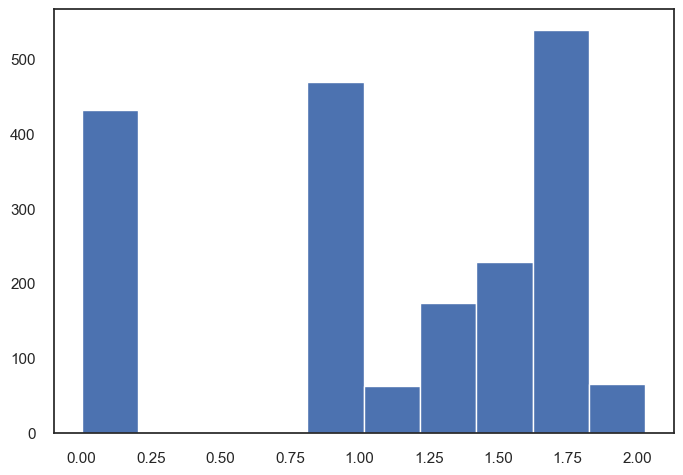

In [241]:
plt.hist(np.sqrt(df["Work_Experience"]))

Mối quan hệ giữa các biến  `numerical`:

In [242]:
display(df.drop(columns="CustomerID").corr())


C:\Users\brocc\AppData\Local\Temp\ipykernel_17776\522768760.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,Age,Annual_Income,Spending_Score,Work_Experience,Family_Size
Age,1.000000,0.089931,-0.029169,0.026500,0.059994
Annual_Income,0.089931,1.000000,0.025989,0.085399,0.095754
Spending_Score,-0.029169,0.025989,1.000000,-0.016236,0.001625
Work_Experience,0.026500,0.085399,-0.016236,1.000000,0.013975
Family_Size,0.059994,0.095754,0.001625,0.013975,1.000000


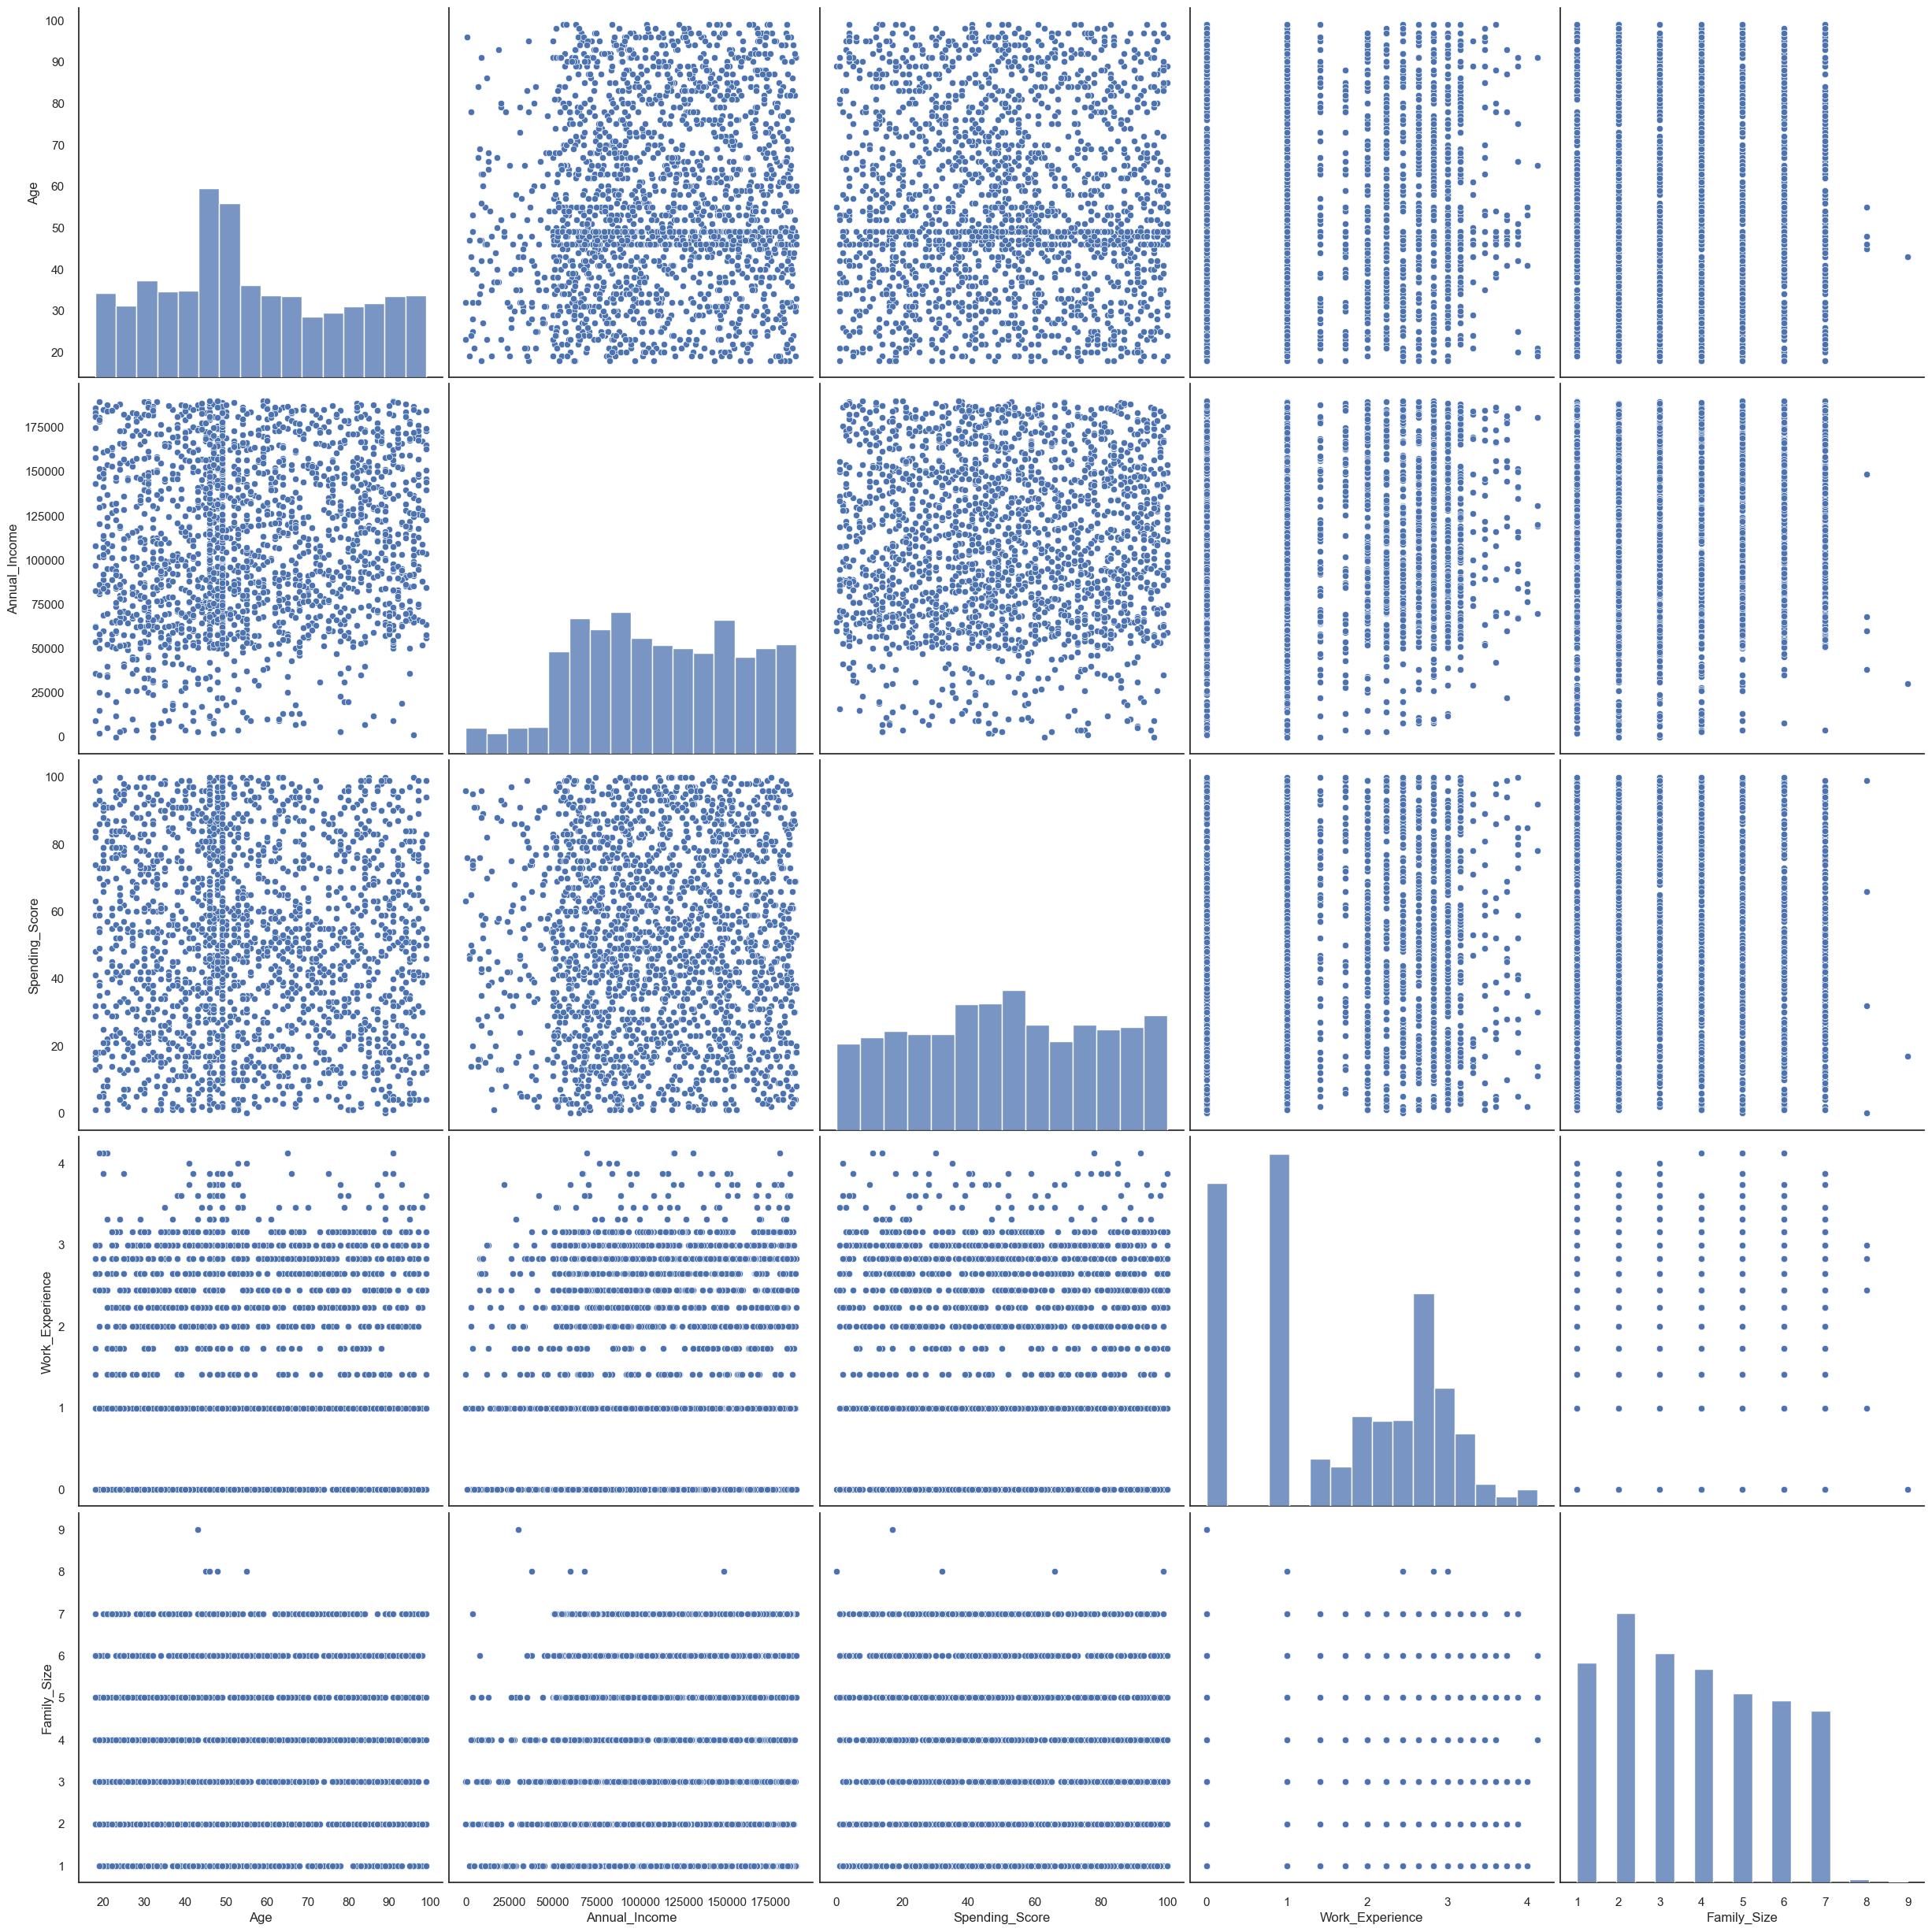

In [243]:
sns.pairplot(df[['Age','Annual_Income','Spending_Score','Work_Experience','Family_Size']],height=5)

Nhìn chung không có quan hệ đồng biến, nghịch biến nào giữa 2 biến một cách rõ ràng, nên ta sẽ sử dụng toàn bộ vào việc xây dựng mô hình.

Đối với các cột dữ liệu `categorical`: Thực hiện kỹ thuật One-hot Encoding để chuyển toàn bộ về dạng `numerical`

In [244]:
encoder=ce.OneHotEncoder(cols=['Gender','Profession'], return_df=True,use_cat_names=True)
df_encoded = encoder.fit_transform(df)

Bỏ cột `CustomerID`

In [245]:
df_encoded=df_encoded.drop(columns=["CustomerID"])

Kiểu dữ liệu của các cột:

In [246]:
df_encoded.dtypes

Gender_Male                   int64
Gender_Female                 int64
Age                           int64
Annual_Income                 int64
Spending_Score                int64
Profession_Healthcare         int64
Profession_Engineer           int64
Profession_Lawyer             int64
Profession_Entertainment      int64
Profession_Artist             int64
Profession_Executive          int64
Profession_Doctor             int64
Profession_Homemaker          int64
Profession_Marketing          int64
Profession_Other              int64
Work_Experience             float64
Family_Size                   int64
dtype: object

Giảm độ chênh lệch giữa các giá trị của các cột bằng Z-Score Normalization:

In [247]:
df_encoded = df_encoded.apply(zscore)
df_encoded=df_encoded.values
df_encoded

array([[ 1.21392672, -1.21392672, -1.7004328 , ..., -0.13452586,
        -0.55337446,  0.11807399],
       [ 1.21392672, -1.21392672, -1.60876163, ..., -0.13452586,
         0.07828422, -0.38954106],
       [-0.82377295,  0.82377295, -1.65459721, ..., -0.13452586,
        -0.55337446, -1.40477117],
       ...,
       [ 1.21392672, -1.21392672,  1.41638717, ..., -0.13452586,
         1.17234913, -0.89715612],
       [ 1.21392672, -1.21392672,  0.95803129, ..., -0.13452586,
         0.86668147, -0.89715612],
       [ 1.21392672, -1.21392672,  1.55389394, ..., -0.13452586,
         0.51318138, -0.89715612]])

#### **2. Mô hình hóa dữ liệu**

In [248]:
# Number of clusters used to calculate the WSS and Silhouette Score
max_clusters = 20

In [249]:
df_encoded.shape

(1969, 17)

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

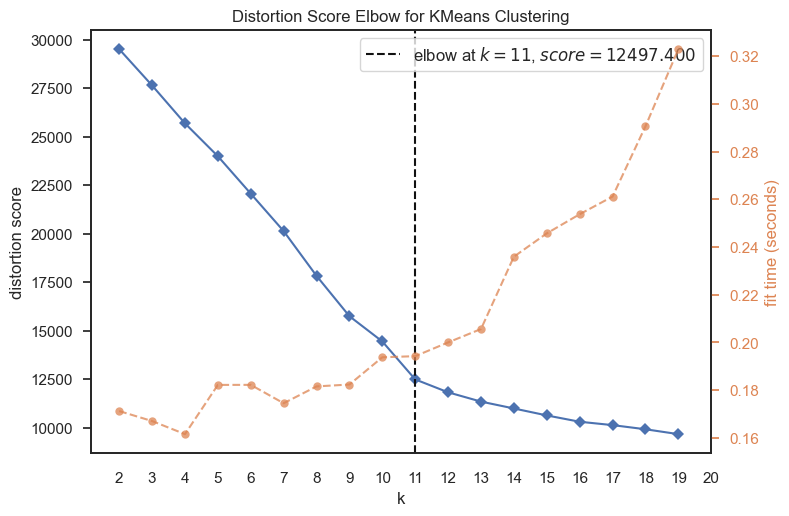

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

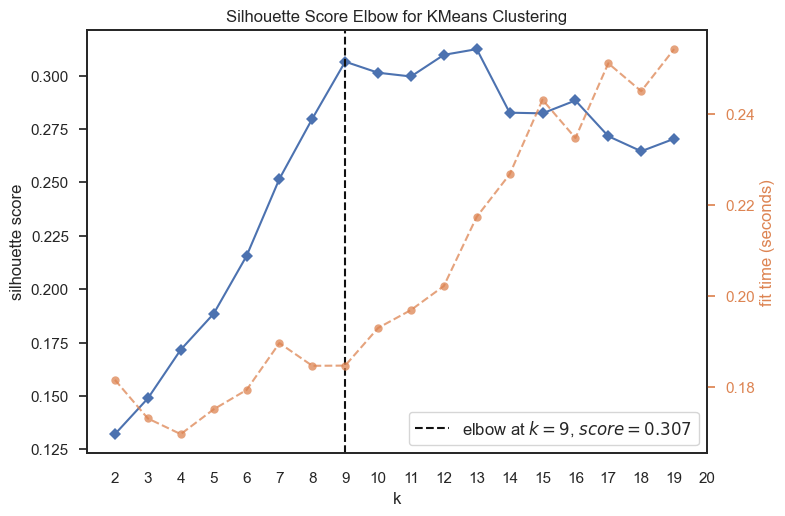

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [250]:
visualizer = KElbowVisualizer(KMeans(), k=(2,max_clusters))
visualizer.fit(df_encoded)     
plt.xticks([i for i in range (2,max_clusters+1)])
visualizer.show() 

visualizer = KElbowVisualizer(KMeans(), k=(2,max_clusters),metric='silhouette')
visualizer.fit(df_encoded)   
plt.xticks([i for i in range (2,max_clusters+1)])    
visualizer.show()     

Có vẻ như việc đưa vào 17 biến dữ liệu để xây dựng mô hình K-mean là không hợp lý. **Elbow Method** và  **Silhouette Score** đều cho số lượng clusters là khá lớn so với mục đích ban đầu phân nhóm khách hàng ở một siêu thị. Ta sẽ thử giảm số lượng biến đưa vào mô hình bằng cách xử dụng PCA để giảm chiều dữ liệu.

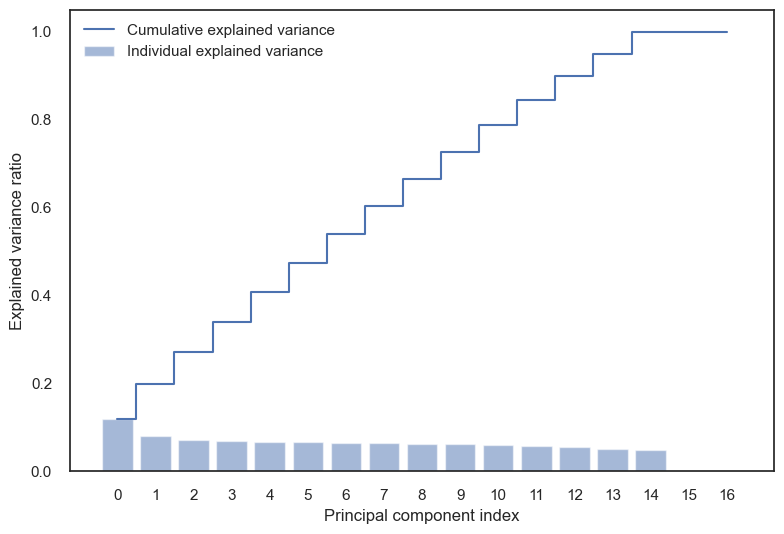

In [251]:
pca = decomposition.PCA()
X_train_pca = pca.fit_transform(df_encoded)

# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.xticks([i for i in range (0,df_encoded.shape[1])])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Ta chọn số chiều sau khi giảm là 3

In [252]:
pca = decomposition.PCA(n_components=3)
df_pca = pca.fit_transform(df_encoded)

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

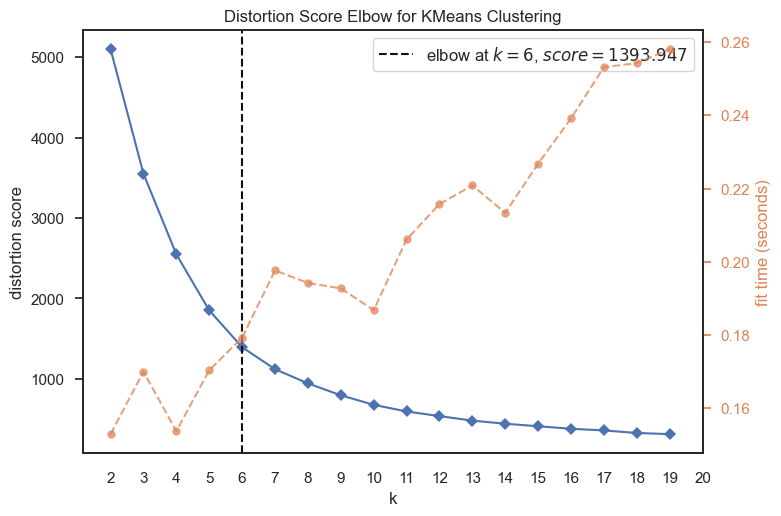

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

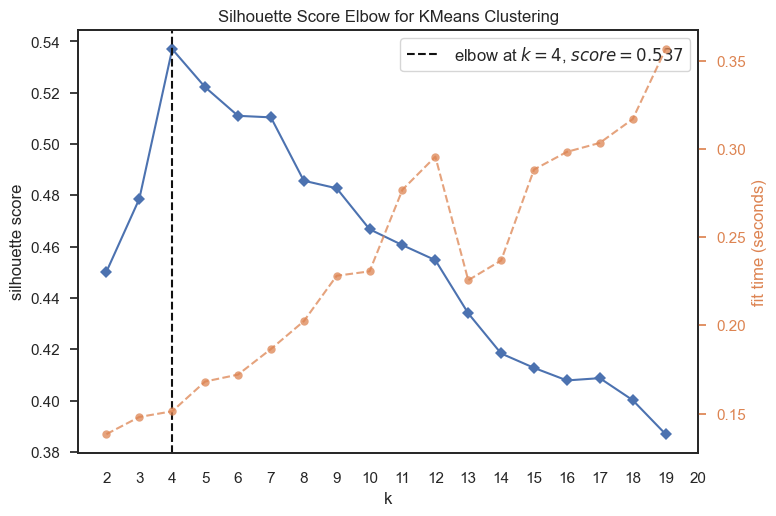

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [253]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(KMeans(), k=(2,20))
visualizer.fit(df_pca)  
plt.xticks([i for i in range (2,max_clusters+1)])      
visualizer.show()  

visualizer = KElbowVisualizer(KMeans(), k=(2,20),metric='silhouette')
visualizer.fit(df_pca)  
plt.xticks([i for i in range (2,max_clusters+1)])     
visualizer.show()        

Ta sẽ chọn số lượng cluster theo **Silhouette Score** cao nhất là 4.

In [254]:
kmeans = KMeans(n_clusters = 4)
y_kmeans = kmeans.fit_predict(df_pca)
y_kmeans

c:\Users\brocc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([2, 2, 0, ..., 2, 2, 2])

In [255]:
df_results=pd.DataFrame(df_pca).rename(columns={0:"X_axis",1:"Y_axis",2:"Z_axis"})
df_results["y_kmeans"]=y_kmeans
df_results["ID"]=df["CustomerID"]
df_results

,X_axis,Y_axis,Z_axis,y_kmeans,ID
0,1.718348,-0.459942,-2.038059,2,1.0
1,1.719396,-0.135791,-1.413436,2,2.0
2,-1.147408,-0.613182,-1.430622,0,3.0
3,-1.255673,-0.105794,-3.181377,0,4.0
4,-1.094036,-1.037008,-1.444433,0,5.0
...,...,...,...,...,...
1964,-1.263228,0.934078,2.500337,3,1965.0
1965,-0.954071,-1.407653,0.998841,0,1966.0
1966,1.850794,-0.726223,0.505698,2,1967.0
1967,1.857581,-0.537332,1.667384,2,1968.0


#### **3. Trực quan hóa mô hình:**

In [256]:
fig = px.scatter_3d(df_results, x="X_axis", y="Y_axis", z="Z_axis",color='y_kmeans',hover_name = "ID")
fig.update_traces(marker_size = 2)
fig.show()